# import pakages

GMM.MyGMM is the pakage which we buide based on sklearn.mixture.BayesianGaussianMixture

The functions in GMM.MyGMM is same as sklearn.mixture.BayesianGaussianMixture except `average_log_likelihood()`

`self.average_log_likelihood(X) `

compute the aveage_log_likelihood of real data X in current mixture model

In [1]:
# import the pakages for vb-gmm
from GMM.VB_GMM import BayesianGaussianMixture
import numpy as np
import pandas as pd

# import the pakages for fed-vb-gmm
import torch
from scipy.stats import norm
from fed_vb_gmm.vmclient import Client
from fed_vb_gmm.vmserver import Server
import syft as sy
import time

# set env which have decentrelised data in three different nodes

there are three clients:alice, bob, charles, they all have partial data of real data Adult.



In [2]:
hook=sy.TorchHook(torch)

# each client only have partial data of real data adult 
clients_conf = [
    {
        "name": "alice",
        "path": "./data/adult/education_0.csv",
        "usecols": [1]
     },
    {
        "name": "bob",
        "path": "./data/adult/education_1.csv",
        "usecols": [1]
     },
    {
        "name": "chalice",
        "path": "./data/adult/education_2.csv",
        "usecols": [1]
     },
]

# age column of real dataset adult
# calculate ave_log_likelihood to evaluation mixture model
adult_age = pd.read_csv("./data/adult/adult_train.csv", usecols=[0])

age = adult_age.values

n_sample = len(age)

# define Fed-VB-GMM function

In this part, we define a Fed-VB-GMM trainning function and calculate the average_log_likelihood.

it build a VB-GMM based on age column in decentralised data adult(education_0, education_1, education_2).

we calculate average_log_likelihood when fed_vb_gmm trains with different n_component parameters.


In [3]:
def fed_vb_gmm_fit(n_components):
    # init server and client
    clients_list = []
    for client_conf in clients_conf:
        clients_list.append(
            Client(client_conf["name"], client_conf["path"],
                          client_conf["usecols"], hook)
        )
    server = Server(n_components=n_components,n_samples=n_sample, weight_concentration_prior_type='dirichlet_process',
                weight_concentration_prior=0.001,init_params="random",max_iter=100,
                n_init=1,hook=hook)
    # create encryption server
    cw = sy.VirtualWorker(hook,id="cw")

    # server connect to clients
    for client in clients_list:
        server.connect_client(client)
        server.connect_cw(cw)
    for client in clients_list:
        client.connect_server(server.server)
        client.connect_other_client(server.clients)
        client.connect_cw(cw)

    # server initialize params

    # calculate means_prior
    sum_list = []
    for client in clients_list:
        sum = client.calcu_means_prior()
        sum_list.append(sum.reshape(-1,1))
    server.calcu_means_prior(sum_list)

    # calculate covariance_prior
    covariances_list = []
    for client in clients_list:
        covariances = client.calcu_covariances_prior(server.means_prior_)
        covariances_list.append(covariances)
    server.calcu_covariances_prior(covariances_list)

    params_prior = server.send_params_prior()
    for client in clients_list:
        client.get_params_prior(params_prior)

    # server initialize rn
    server.initialize_rn(np.random.mtrand._rand)
    nk = server.init_nk()
    resp_list = server.send_resp()

    max_lower_bound = -np.infty
    server.converged_ = False

    for init in range(server.n_init):
        # if don't warm start, begin initalization
        #-----------------------------------------
        # clients calculate x_sum
        x_sum_list = []
        for client in clients_list:
            x_sum = client.calcu_x_sum()
            x_sum_list.append(x_sum)

        # server calculate xk,nk, then update parameters
        xk = server.calcu_x_bar(x_sum_list, nk)
        params = server.estimate_params(nk, xk)

        # clients finish m_step
        # don't calculate low_bound when initialization
        sk_list = []
        for client in clients_list:
            sk, tmp1, tmp2 = client.m_step(params)
            sk_list.append(sk)
            if client == clients_list[1]:
                covariances_ = tmp1

        # server merge
        sk, covariances_ = server.aggregation_and_convergence_check(params, sk_list, covariances_)
        #--------------------------------------------------------------------------------------
        # set a most minimal lower_bound
        lower_bound = -np.infty

        # start trainning
        for n_iter in range(1, server.max_iter + 1):
            prev_lower_bound = lower_bound
            iter_start = time.time()
            # print(n_iter)
            log_likelihood_list = []
            if n_iter % 10 == 0:
                real = age
                likelihood_x = 0
                weight_concentration_ = params["weight_concentration_"].numpy()
                means_ = params["means_"].numpy()
                weights = (weight_concentration_ / np.sum(weight_concentration_))
                for j in range(server.n_components):
                    mean = means_[j]
                    cov = covariances_[j]
                    weight = weights[j]
                    pdf_component = norm.pdf(real.reshape(len(real)), loc=mean, scale=cov)
                    likelihood_x += pdf_component * weight
                log_likelihood_x = np.log(likelihood_x)
                ave_log_likelihood = np.average(log_likelihood_x)
                log_likelihood_list.append(ave_log_likelihood)

            # e_step
            xk_client_list = []
            log_resp_list = []
            resp_list = []
            resp_ptr_list = []
            start = time.time()
            for client in clients_list:
                xk_client, log_resp, resp, _ = client.e_step(sk_list,covariances_,params)
                xk_client_list.append(xk_client)
                log_resp_list.append(log_resp)
                # resp_list.append(torch.exp(log_resp))
                resp_list.append(resp)
                resp_ptr_list.append(_)
            end = time.time()
            spend_time = end - start

            # server m_step
            start = time.time()
            nk, xk, params = server.m_step(xk_client_list, resp_list)

            # client m_step
            sk_list = []
            for client in clients_list:
                sk, tmp1, tmp2 = client.m_step(params, if_init=True, log_resp=log_resp_list)
                sk_list.append(sk)
                if client == clients_list[0]:
                    lower_bound = tmp2.get().numpy()
                    # lower_bound = tmp2.get()
                elif client == clients_list[1]:
                    covariances_ = tmp1
            end = time.time()
            spend_time = end - start

            # server merge
            start = time.time()
            sk, covariances_ = server.aggregation_and_convergence_check(params, sk_list, covariances_)

            end = time.time()
            spend_time = end - start

            iter_end = time.time()
            spend_time = iter_end-iter_start

            change = lower_bound - prev_lower_bound
            if abs(change) < server.tol:
                server.converged_ = True
                break

        # iterative update
        if lower_bound > max_lower_bound:
            max_lower_bound = lower_bound
            best_params = (
                clients_list[0].weight_concentration_,
                clients_list[0].mean_precision_,
                clients_list[0].means_,
                clients_list[0].degrees_of_freedom_,
                covariances_,
                clients_list[0].precision_cholesky_
            )
            best_n_iter = n_iter

            # log_resp_list = []
            # for client in clients_list:
            #     a, log_resp,b,c = client.e_step(sk_list,covariances_,params)
            #     log_resp_list.append(log_resp.get().float_precision().numpy())
            # log_resp = np.concatenate(log_resp_list, axis=0).reshape(-1, server.n_components)
            # result = log_resp.argmax(axis=1)
            # pass
        
        return ave_log_likelihood

In [4]:
n_components_params = [2, 4, 8, 16, 32]
ave_log_likelihood_list = []
for n_components in n_components_params:
    ave_log_likelihood = fed_vb_gmm_fit(n_components)
    ave_log_likelihood_list.append(ave_log_likelihood)
    print("whe n_components is {}, ave_log_likelihood is {}".format(n_components, ave_log_likelihood))

/root/anaconda3/envs/swarm-learning/lib/python3.6/site-packages/syft/frameworks/torch/hook/hook.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)


whe n_components is 2, ave_log_likelihood is -5.235562857325593
whe n_components is 4, ave_log_likelihood is -4.7792612538775545
whe n_components is 8, ave_log_likelihood is -4.660632018715773
whe n_components is 16, ave_log_likelihood is -4.64244312269794
whe n_components is 32, ave_log_likelihood is -4.660537834483193


In [6]:
base_ave_log_likelihood_list = []
for n_components in n_components_params:
    bgm = BayesianGaussianMixture(n_components=n_components, weight_concentration_prior_type='dirichlet_distribution',
            weight_concentration_prior=0.001,init_params="random",max_iter=100,
            n_init=1)
    bgm.fit(age)
    ave_log_likelihood = bgm.average_log_likelihood(age)
    base_ave_log_likelihood_list.append(ave_log_likelihood)
    print("whe n_components is {}, ave_log_likelihood is {}".format(n_components, ave_log_likelihood))

/root/Desktop/fedvbgmm/GMM/MyGMM.py:957: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


whe n_components is 2, ave_log_likelihood is -5.229613078132284


/root/Desktop/fedvbgmm/GMM/MyGMM.py:957: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


whe n_components is 4, ave_log_likelihood is -4.8600537417908605


/root/Desktop/fedvbgmm/GMM/MyGMM.py:957: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


whe n_components is 8, ave_log_likelihood is -4.792928510506753


/root/Desktop/fedvbgmm/GMM/MyGMM.py:957: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


whe n_components is 16, ave_log_likelihood is -4.7629278498171965
whe n_components is 32, ave_log_likelihood is -4.77854643073494


/root/Desktop/fedvbgmm/GMM/MyGMM.py:957: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


# matplot

In [7]:
likelihood = base_ave_log_likelihood_list
likelihood

[-5.229613078132284,
 -4.8600537417908605,
 -4.792928510506753,
 -4.7629278498171965,
 -4.77854643073494]

In [8]:
fed_likelihood = ave_log_likelihood_list
fed_likelihood

[-5.235562857325593,
 -4.7792612538775545,
 -4.660632018715773,
 -4.64244312269794,
 -4.660537834483193]

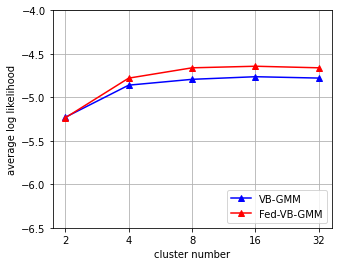

In [11]:
from matplotlib import rcParams
import matplotlib.pyplot as plt

config = {
    "font.family":'Times New Roman',
}
rcParams.update(config)


plt.figure(figsize=(5,4))
n_components_list = [1,2,3,4,5]
plt.xlabel('cluster number')
plt.ylabel('average log likelihood')
plt.plot(n_components_list, likelihood,linestyle = '-', label='VB-GMM',color='blue',
         marker = '^', 
        )
plt.plot(n_components_list, fed_likelihood,linestyle = '-', label='Fed-VB-GMM',color='red',
         marker = '^', 
        )
plt.xticks([1,2,3,4,5], ["2","4","8","16","32"])
yticks = np.arange(-4,-7,-0.5)
plt.yticks(yticks)
plt.grid(True)
plt.legend(loc='lower right')